## Library Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import texthero as hero
from texthero import preprocessing
from wordcloud import WordCloud, STOPWORDS

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import torch

from datasets import load_dataset, load_metric
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification

%matplotlib inline

## Exploratory Data Analysis

In [3]:
# Load in Fake and True news
fake_news = pd.read_csv("data/Fake.csv", sep=',')
true_news = pd.read_csv("data/True.csv", sep=',')

print(f'There is a total of {len(fake_news)} fake news and a total of {len(true_news)} true news.')

There is a total of 23481 fake news and a total of 21417 true news.


In [3]:
# Check for duplicate texts
print('Number of duplicated texts in the fake news data:', fake_news['text'].duplicated().sum())
# Display a few rows of the fake news data
fake_news.head()

Number of duplicated texts in the fake news data: 6026


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# Check for duplicate texts
print('Number of duplicated texts in the true news data:', true_news['text'].duplicated().sum())
# Display a few rows of the true news data
true_news.head()

Number of duplicated texts in the true news data: 225


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Remove text duplicates in the fake and true news data. Otherwise, building a model with a dataset with duplicated text entries would lead to biased results.

In [5]:
# Remove text duplicates
fake_news.drop_duplicates(subset=['text'], keep='first', inplace=True, ignore_index=False)
true_news.drop_duplicates(subset=['text'], keep='first', inplace=True, ignore_index=False)
print('Fake news data shape: ', fake_news.shape)
print('True news data shape: ', true_news.shape)

Fake news data shape:  (17455, 4)
True news data shape:  (21192, 4)


A common practice when developing ML models is to do data cleaning, and in NLP with text data is no exception.

I will use the [`Texthero`](https://texthero.org/) library to "clean" the text. Texthero is a Python package that allows you to work efficiently and quickly with text data. In this case, the text is transformed to lowercase, then I remove URLs, digits, punctuations, diacritics and accents, stopwords, and long white spaces.

In [6]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.remove_urls,
                   preprocessing.lowercase,
                   preprocessing.remove_digits,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_stopwords,
                   preprocessing.remove_whitespace]
fake_news['text_clean'] = hero.clean(fake_news['text'], custom_pipeline)
true_news['text_clean'] = hero.clean(true_news['text'], custom_pipeline)

In [7]:
# Remove the entries with no text or very small text (<5 characters).
fake_news.drop(fake_news[fake_news.text_clean.str.len() < 5].index, inplace=True)
true_news.drop(true_news[true_news.text_clean.str.len() < 5].index, inplace=True)
print('Fake news data shape: ', fake_news.shape)
print('True news data shape: ', true_news.shape)

Fake news data shape:  (17398, 5)
True news data shape:  (21191, 5)


**Visualizing news distribution by subject.**

The following figures show that, in the case of fake data, the news' topic is mostly "News" or "Politics". While the true news data is fairly balanced between "politic" and "world news".

In [8]:
def plot_news_by_subject(df, fake_true):
    data_plot = df['subject'].value_counts()
    
    # increase plot resolution
    # mpl.rcParams['figure.dpi'] = 200
    plt.figure(figsize=(10, 6))
    plt.title('Number of '+fake_true+' News by Subject', fontsize=14)
    plt.xlabel('News Subject', fontsize=12)
    plt.ylabel('Number of News', fontsize=12)
    sns.barplot(x=data_plot.index, y=data_plot.values)
    plt.show()
    return

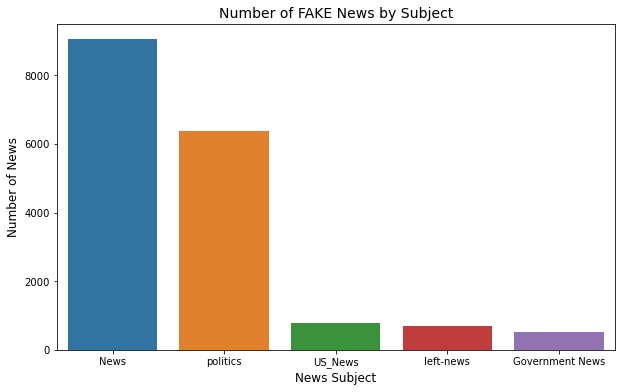

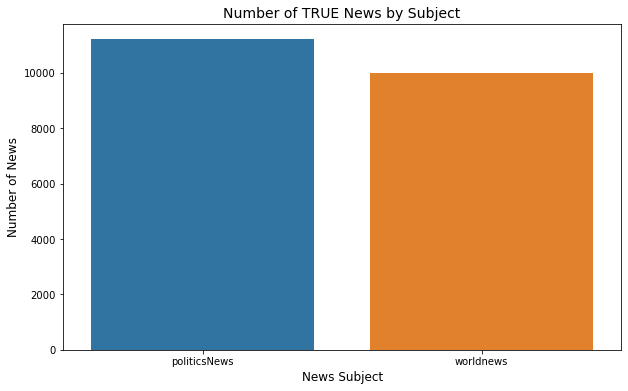

In [9]:
plot_news_by_subject(fake_news, 'FAKE')
plot_news_by_subject(true_news, 'TRUE')

### Word Frequency Analysis

The following two word-cloud images give us an idea of the most common/frequent words in the fake and true news data.

In [10]:
def generate_wordcloud(df, graph_title: str, text_field: str):
    text = df[text_field].values
    plt.figure(figsize=(15, 8))
    wc = WordCloud(
        width = 1500,
        height = 500,
        stopwords=STOPWORDS
    ).generate(" ".join(text))
    plt.title("{} News Word Cloud".format(graph_title), fontsize=20)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    return

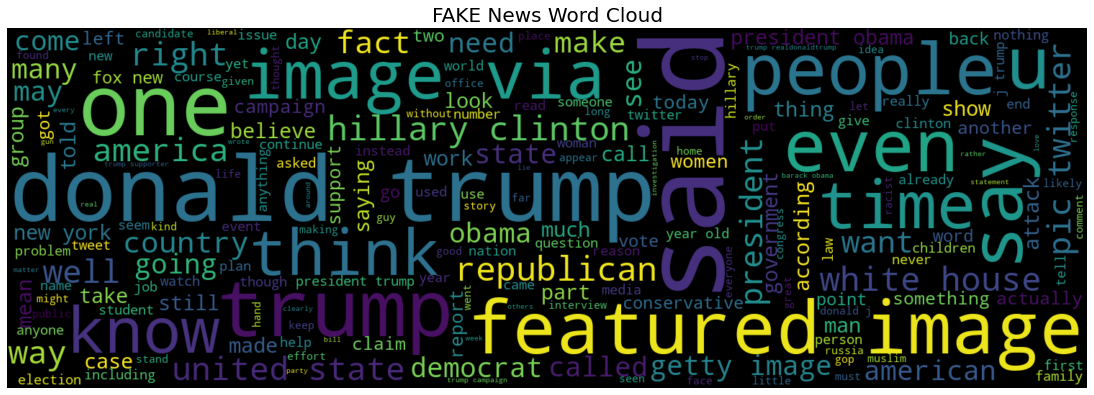

In [11]:
# Generate word-cloud for the fake news data
generate_wordcloud(df=fake_news, graph_title='FAKE', text_field='text_clean')

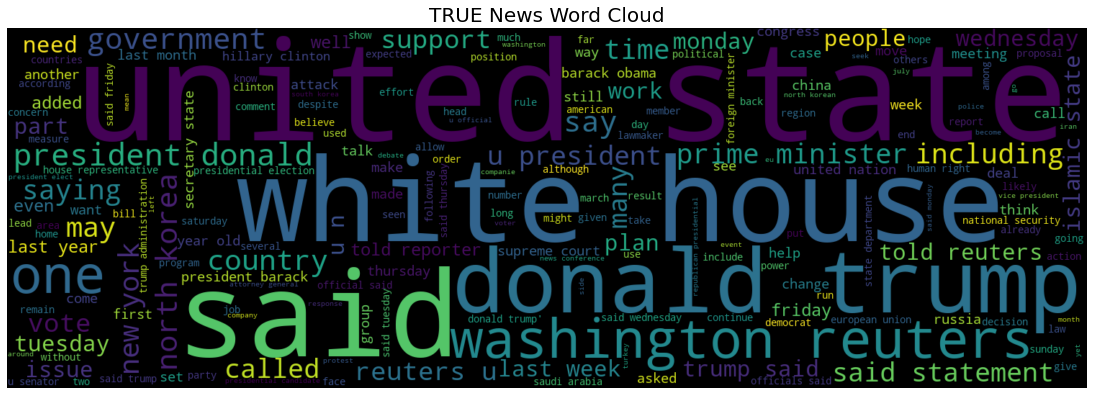

In [12]:
# Generate word-cloud for the true news data
generate_wordcloud(df=true_news, graph_title='TRUE', text_field='text_clean')

The following figures present information about the most frequent two-word combination in the fake and true text data. The following functions are borrowed from [this notebook](https://www.kaggle.com/swathi314/toxic-comments-eda-non-semantic-baseline?scriptVersionId=50812505).

The analysis is limited to a random set of 5000 text samples to speed up the execution. I also performed this analysis for the entire set and the most frequent words were the same. Therefore, these results from 5000 samples are representative of the entire set.

In [13]:
## Gram statistics
def gram_analysis(data, gram):
    tokens=[t for t in data.lower().split(" ")]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def gram_freq(df, gram: int, category: str, text_col: str, num_samples: int):
    category_text = " ".join(df[text_col].sample(num_samples).values)
    toks = gram_analysis(category_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.title("{} news most common {}-word tokens".format(category, gram))
    sns.barplot(x='frequency', y='token', data=tok_freq.iloc[:30], orient='h')
    plt.xticks(rotation=90)
    plt.show()
    return 

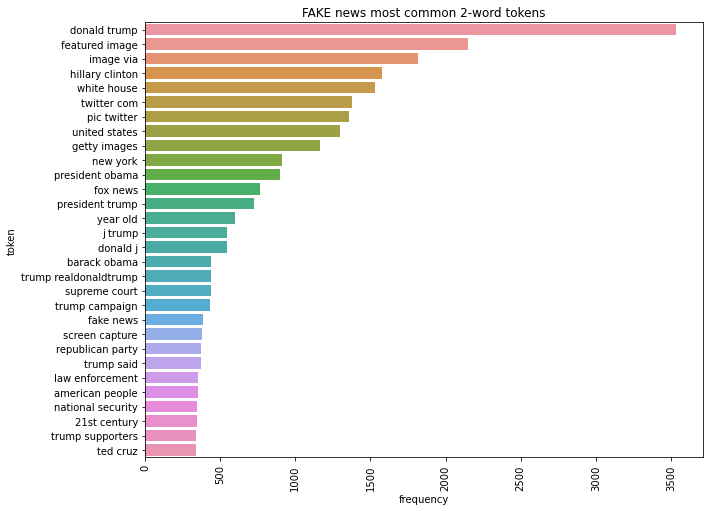

In [14]:
gram_freq(df=fake_news, gram=2, category='FAKE', text_col='text_clean', num_samples=5000)

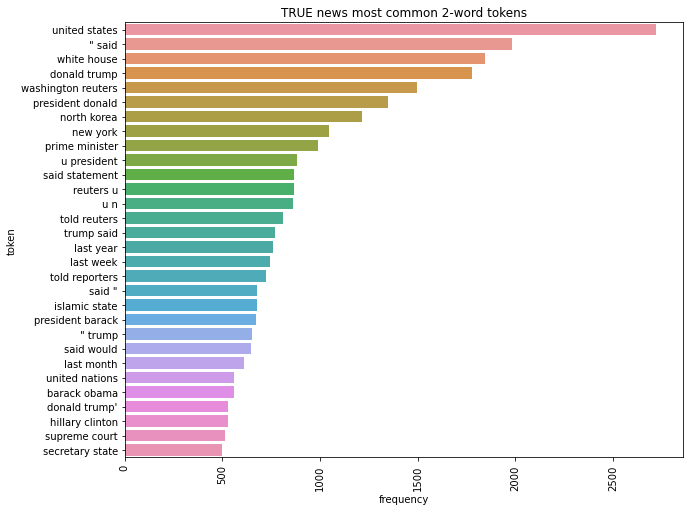

In [15]:
gram_freq(df=true_news, gram=2, category='TRUE', text_col='text_clean', num_samples=5000)

The graphs above show that both fake and real news share practically the same vocabulary, which is understandable since "politics" is the main topic of both sets. In the fake set, "donald trump" is the most frequent combination, whereas in the true set it is "united states".

Let's explore the same analysis for the most frequent three-word combination.

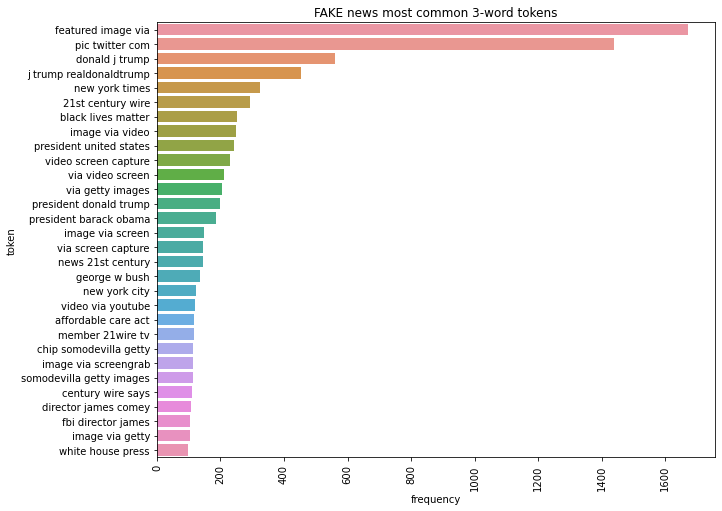

In [16]:
gram_freq(df=fake_news, gram=3, category='FAKE', text_col='text_clean', num_samples=5000)

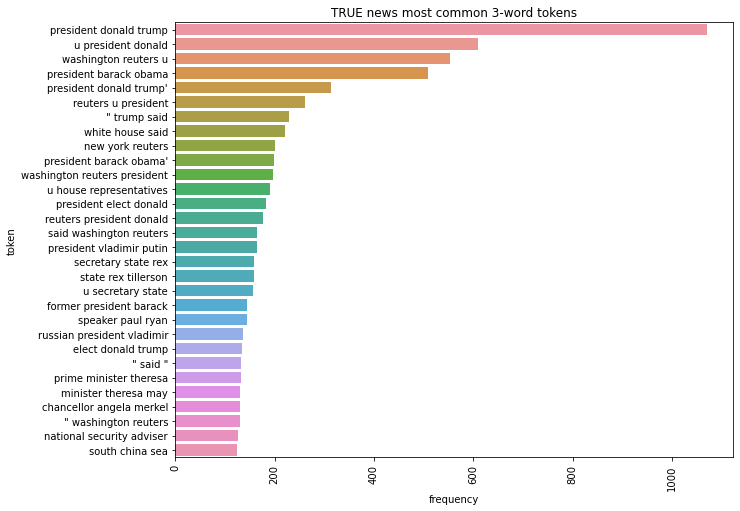

In [17]:
gram_freq(df=true_news, gram=3, category='TRUE', text_col='text_clean', num_samples=5000)

Now, let's add a `label` columns to each dataset with `1` to the true news and `0` to the fake news.

At this point, the set of fake and true news has a total of `17398` and `21191` samples, respectively. Due to computational limitations, I will only use a subset of these samples while ensuring an equal number of fake and true news (i.e., `17390`).

In [18]:
# Adding labels 
true_news['label'] = np.ones(len(true_news), dtype=int)
fake_news['label'] = np.zeros(len(fake_news), dtype=int)

news_data = pd.concat([true_news.sample(n=17390), fake_news.sample(n=17390)])
print('Dataset size: ', news_data.shape)
news_data.head()

Dataset size:  (34780, 6)


,title,text,subject,date,text_clean,label
9701,California senate approves bill ending mandato...,"SACRAMENTO, Calif. (Reuters) - California woul...",politicsNews,"May 4, 2016",sacramento calif reuters california would repe...,1
3464,U.N. says U.S. withdrawal from Paris deal 'maj...,UNITED NATIONS (Reuters) - The United States’ ...,politicsNews,"June 1, 2017",united nations reuters united states' decision...,1
3335,Top Senate intelligence Democrat: 'more invest...,WASHINGTON (Reuters) - The top Democrat on the...,politicsNews,"June 7, 2017",washington reuters top democrat u senate intel...,1
20146,Evacuated Islamic State fighters reach Syria's...,BEIRUT (Reuters) - Buses carrying evacuated Is...,worldnews,"September 13, 2017",beirut reuters buses carrying evacuated islami...,1
16589,Mozambique's president dismisses head of intel...,MAPUTO (Reuters) - Mozambique has fired its he...,worldnews,"October 24, 2017",maputo reuters mozambique fired head intellige...,1


Drop all columns except `text_clean` and `label`, the rest won't be used for prediction.

An alternative could be to merge the title with the text and use the resulting text to train the model. However, I did some tests and the results were the same with and without the title. Then, I decided not to include the title.

In [19]:
columns_to_drop = [item for item in news_data.columns if item not in ('label', 'text_clean')]
news_data = news_data.drop(columns_to_drop, axis=1)
news_data = news_data[['text_clean', 'label']]
news_data.head()

,text_clean,label
9701,sacramento calif reuters california would repe...,1
3464,united nations reuters united states' decision...,1
3335,washington reuters top democrat u senate intel...,1
20146,beirut reuters buses carrying evacuated islami...,1
16589,maputo reuters mozambique fired head intellige...,1


In [20]:
# Split the data into train, validation, and test set.
X_train, X_rest, y_train, y_rest = train_test_split(news_data['text_clean'], news_data['label'],
                                                    stratify=news_data['label'],
                                                    train_size=0.70, random_state=42)

print('Label distribution in the train set:')
print(pd.DataFrame(y_train).value_counts())
news_data_train = pd.DataFrame({'text_clean': X_train, 'label': y_train})

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.50,
                                                stratify=y_rest, random_state=42)

print('Label distribution in the validation set:')
print(pd.DataFrame(y_val).value_counts())
news_data_val = pd.DataFrame({'text_clean': X_val, 'label': y_val})

print('Label distribution in the test set:')
print(pd.DataFrame(y_test).value_counts())
news_data_test = pd.DataFrame({'text_clean': X_test, 'label': y_test})

Label distribution in the train set:
label
0        12173
1        12173
dtype: int64
Label distribution in the validation set:
label
1        2609
0        2608
dtype: int64
Label distribution in the test set:
label
0        2609
1        2608
dtype: int64


In [21]:
# Save data to csv files
news_data_train.to_csv('data/news_data_train.csv', sep=',', index=False)
news_data_val.to_csv('data/news_data_val.csv', sep=',', index=False)
news_data_test.to_csv('data/news_data_test.csv', sep=',', index=False)

## Modelling
In this section I will train and evaluate three binary classifiers:

- **DistilBERT** and **ALBERT Base v1** using implementations from the `Hugging Face` framework. Input features will be derived using the models' tokenizers.
- **XGBoost Classifier** from the [`XGBoost`](https://xgboost.readthedocs.io/) library with TF-IDF features.

### DistilBERT
I will use transfer learning to train a pretrained "Distilled"-BERT model for fake news detection. According to the [documentation](https://github.com/huggingface/transformers/tree/master/examples/research_projects/distillation#what-is-distil):

_DistilBERT is a small, fast, cheap and light Transformer model based on Bert architecture. It has 40% less parameters than `bert-base-uncased`, runs 60% faster while preserving 97% of BERT's performances as measured on the GLUE language understanding benchmark._

The BERT model (proposed by researchers at Google) revolutionized the NLP field achieving state-of-the-art results in many tasks. Thus, a good option for this text classification task.

In [22]:
def tokenize_function(examples):
    """
    Function to tokenize the text, i.e., converting the raw text into numbers.
    The resulting samples will have the same number of tokens, in this case is
    set to the maximum length the model can accept (i.e., 512). This is achieved
    by padding or truncating.
    
    :param examples: Item object class dataset containing the text.
    :return: Tokenized text.
    """
    return tokenizer(examples['text_clean'], padding="max_length", truncation=True)


def compute_metrics(eval_pred):
    """
    Compute two evaluation metrics for a given model prediction.
    Accuracy and F1-Score is computed by default.
    
    :param eval_pred: Model prediction.
    :return: dict: Dictionary with metrics' name as keys. 
    """
    name_metric1, name_metric2 = 'accuracy', 'f1'
    metric1 = load_metric(name_metric1)
    metric2 = load_metric(name_metric2)

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric1_result = metric1.compute(predictions=predictions, references=labels)[name_metric1]
    metric2_result = metric2.compute(predictions=predictions, references=labels)[name_metric2]
    return {name_metric1: metric1_result, name_metric2: metric2_result}

In [23]:
# Load the "distilbert" tokenizer to convert word to a number representation.
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

# Create a training, validation, and test dataset from csv files saves previously.
dataset = load_dataset('csv', data_files={x: 'data/news_data_'+x+'.csv'
                                          for x in ['train', 'val', 'test']})

# Tokenize the entire dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Using custom data configuration default-7ec7955e7c6e09d9


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\Rafael Zequeira\.cache\huggingface\datasets\csv\default-7ec7955e7c6e09d9\0.0.0\bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [28]:
# Subsample the datajset to speed-up training
small_tokenized_datasets_train = tokenized_datasets["train"].shuffle().select(range(15000))
# small_tokenized_datasets_val = tokenized_datasets["val"].shuffle().select(range(100))
# small_tokenized_datasets_test = tokenized_datasets["test"].shuffle().select(range(100))

**DistilBERT** has 6 transformer layers and a total of 65M parameters. I will freeze the embeddings layer and the first 3 transformer layers to train a bit faster, and to reduce the chances of overfitting. Freezing the layers means disabling gradient computation and backpropagation for these layers' weights. This is a common practice in NLP or Computer Vision when working with small datasets. Also, according to [this post](https://raphaelb.org/posts/freezing-bert/), it appears that freezing a few layers for transfer learning does not significantly affect the accuracy of a BERT model.

In [25]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

# First let's freeze here the embeddings of the model
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

# Now let's freeze the first three transformer blocks
for layer in model.distilbert.transformer.layer[:3]:
    for param in layer.parameters():
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bia

65,783,042 total number of parameters
21,855,746 parameters to train


In [47]:
training_args = TrainingArguments("test_trainer", dataloader_num_workers=4,
                                  report_to='all', evaluation_strategy="epoch",
                                  per_device_eval_batch_size=16,
                                  per_device_train_batch_size=16)

# 3 Epochs by default
trainer = Trainer(
    model=model, args=training_args,
    train_dataset=small_tokenized_datasets_train,
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics
)

PyTorch: setting up devices


In [30]:
# Train the pre-trained DistilBERT model.
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running training *****
  Num examples = 15000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2814


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.015200,0.005413,0.999233,0.999234
2,0.003400,0.001975,0.999617,0.999617
3,0.001100,0.004531,0.999617,0.999617


Saving model checkpoint to test_trainer\checkpoint-500
Configuration saved in test_trainer\checkpoint-500\config.json
Model weights saved in test_trainer\checkpoint-500\pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
  Num examples = 5217
  Batch size = 16
Saving model checkpoint to test_trainer\checkpoint-1000
Configuration saved in test_trainer\checkpoint-1000\config.json
Model weights saved in test_trainer\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to test_trainer\checkpoint-1500
Configuration saved in test_trainer\checkpoint-1500\config.json
Model weights saved in test_trainer\checkpoint-1500\pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
 

TrainOutput(global_step=2814, training_loss=0.005151858402041463, metrics={'train_runtime': 1690.2075, 'train_samples_per_second': 26.624, 'train_steps_per_second': 1.665, 'total_flos': 5961032939520000.0, 'train_loss': 0.005151858402041463, 'epoch': 3.0})

In [31]:
# Evaluate the model on the validation dataset.
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
  Num examples = 5217
  Batch size = 16


{'eval_loss': 0.004531164187937975,
 'eval_accuracy': 0.9996166379145103,
 'eval_f1': 0.999616858237548,
 'eval_runtime': 88.9125,
 'eval_samples_per_second': 58.676,
 'eval_steps_per_second': 3.678,
 'epoch': 3.0}

In [32]:
# Evaluate the model on the test dataset.
trainer = Trainer(
    model=model, args=training_args,
    train_dataset=small_tokenized_datasets_train,
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
  Num examples = 5217
  Batch size = 16


{'eval_loss': 0.0003584846272133291,
 'eval_accuracy': 0.9998083189572551,
 'eval_f1': 0.9998083189572551,
 'eval_runtime': 90.385,
 'eval_samples_per_second': 57.72,
 'eval_steps_per_second': 3.618}

As shown by the previous results the DistilBERT model performs very good, it achieved an accuracy of **0.9996** and **0.9998** on the entire validation and test set, respectively. And F1-score of **0.9996** and **0.9998** on the entire validation and test set, respectively.

### ALBERT Base v1

ALBERT was also proposed by researchers at Google in 2019. Their goal was to improve the training and results of the BERT architecture by using different techniques like parameter sharing, factorization of embedding matrix, and Inter-sentence coherence loss.

The _factorized embedding parameterization_ technique leads to an 80% reduction of the model parameters with a minimal drop in performance compared to BERT. I decided to test this model since the parameter reduction should favor training speed while maintaining similar performance.

The pipeline is almost the same as with the DistilBERT model. The `batch_size` has been reduced to 4 to avoid running into an "out of memory" error when executing on my local system.

In [39]:
tokenizer = AutoTokenizer.from_pretrained("albert-base-v1")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_tokenized_datasets_train = tokenized_datasets["train"].shuffle().select(range(6000))
# small_tokenized_datasets_val = tokenized_datasets["val"].shuffle().select(range(2000))

model2 = AutoModelForSequenceClassification.from_pretrained("albert-base-v1", num_labels=2)

# Freeze the embeddings of the model
for param in model2.albert.embeddings.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model2.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v1/resolve/main/config.json from cache at C:\Users\Rafael Zequeira/.cache\huggingface\transformers\93ddc3e8df1e0ef845f777cce9adb8292ea7649aded41347e1868666fe3495fa.026c3e14139b744b36c015e2f6517310a5e31ea4c089e595d05f27d651b155c8
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
 

11,685,122 total number of parameters
7,779,074 parameters to train


In [40]:
training_args = TrainingArguments("test_trainer", dataloader_num_workers=4,
                                  report_to='all', evaluation_strategy="epoch",
                                  per_device_eval_batch_size=4,
                                  per_device_train_batch_size=4)

trainer2 = Trainer(
    model=model2, args=training_args,
    train_dataset=small_tokenized_datasets_train,
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics
)
trainer2.train()

PyTorch: setting up devices
The following columns in the training set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4500


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.028300,0.014351,0.998083,0.998087
2,0.000000,0.004079,0.999617,0.999617
3,0.004500,0.003927,0.999042,0.999043


Saving model checkpoint to test_trainer\checkpoint-500
Configuration saved in test_trainer\checkpoint-500\config.json
Model weights saved in test_trainer\checkpoint-500\pytorch_model.bin
Saving model checkpoint to test_trainer\checkpoint-1000
Configuration saved in test_trainer\checkpoint-1000\config.json
Model weights saved in test_trainer\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to test_trainer\checkpoint-1500
Configuration saved in test_trainer\checkpoint-1500\config.json
Model weights saved in test_trainer\checkpoint-1500\pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
  Num examples = 5217
  Batch size = 4
Saving model checkpoint to test_trainer\checkpoint-2000
Configuration saved in test_trainer\checkpoint-2000\config.json
Model weights saved in test_trainer\checkpoint-2000\pytorch_model.bin
Saving model

TrainOutput(global_step=4500, training_loss=0.022042259673070577, metrics={'train_runtime': 2244.5343, 'train_samples_per_second': 8.019, 'train_steps_per_second': 2.005, 'total_flos': 430165831680000.0, 'train_loss': 0.022042259673070577, 'epoch': 3.0})

In [41]:
# Evaluate model2 on the validation dataset.
trainer2.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
  Num examples = 5217
  Batch size = 4


{'eval_loss': 0.003926537930965424,
 'eval_accuracy': 0.9990415947862756,
 'eval_f1': 0.9990426957687153,
 'eval_runtime': 182.2195,
 'eval_samples_per_second': 28.63,
 'eval_steps_per_second': 7.162,
 'epoch': 3.0}

In [42]:
# Evaluate model2 on the test dataset.
trainer2 = Trainer(
    model=model, args=training_args,
    train_dataset=small_tokenized_datasets_train,
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text_clean.
***** Running Evaluation *****
  Num examples = 5217
  Batch size = 16


{'eval_loss': 0.0003584846272133291,
 'eval_accuracy': 0.9998083189572551,
 'eval_f1': 0.9998083189572551,
 'eval_runtime': 89.1345,
 'eval_samples_per_second': 58.53,
 'eval_steps_per_second': 3.669}

As shown by the previous results the `ALBERT Base v1` model performs very good, it achieved an accuracy of **0.999** and **0.9998** on the validation and test set, respectively. And F1-score of **0.999** and **0.9998** on the validation and test set, respectively.

### XGBoost Classifier

Transformer based models are the state-of-the-art for NLP tasks. However, building and training these models is very demanding, as it requires a lot of resources and computational power. In contrast, the XGBoost classifier is an optimized distributed gradient boosting machine learning algorithm designed to be highly efficient and flexible. XGBoost has been used sucessfully for many different tasks and it is easier to develop with limited resources. Therefore, I will test its performance for fake news detection.

I will train the XGBoost classifier with TF-IDF features. TF-IDF stands for _"Term Frequency–Inverse Document Frequency"_, it is a numerical statistic intended to reflect how important a word is to a document in a collection or corpus. Basically, the value of a word increases proportionally to the count, but is inversely proportional to the frequency of the word in the corpus.

I use the `TfidfVectorizer` from `scikit-learn` with a limit of 10000 words (the length of the vocabulary will be 10k), and capturing unigrams.

In [43]:
# Word level tf-idf
tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
train_tfidf = tfidf_vectorizer.fit_transform(news_data_train['text_clean'])
val_tfidf = tfidf_vectorizer.transform(news_data_val['text_clean'])
test_tfidf = tfidf_vectorizer.transform(news_data_test['text_clean'])
train_tfidf.shape

(24346, 10000)

The resulting training set has 10000 features, this is quite a lot, and more considering that there are 30556 text samples in the training set. Therefore, I perform dimensionality reduction using truncated SVD (aka _" latent semantic analysis (LSA)"_) from the `scikit-learn` library. I will reduce to 100 input features.

In [44]:
svd = TruncatedSVD(n_components=100, random_state=42)
train_tfidf_svd = svd.fit_transform(train_tfidf)
val_tfidf_svd = svd.transform(val_tfidf)
test_tfidf_svd = svd.transform(test_tfidf)

Next, the `XGBClassifier` is defined with 500 boosting rounds, and fitted to the reduced train_TD-IDF feature set.

In [45]:
clf = XGBClassifier(n_estimators=500, n_jobs=-1)

clf.fit(train_tfidf_svd, news_data_train['label'],
        eval_set=[(val_tfidf_svd, news_data_val['label'])], verbose=True)

[23:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.49913
[1]	validation_0-logloss:0.38847


C:\Miniconda3\envs\PyTorch\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.31743
[3]	validation_0-logloss:0.26821
[4]	validation_0-logloss:0.23404
[5]	validation_0-logloss:0.20906
[6]	validation_0-logloss:0.18892
[7]	validation_0-logloss:0.17251
[8]	validation_0-logloss:0.16174
[9]	validation_0-logloss:0.15113
[10]	validation_0-logloss:0.14389
[11]	validation_0-logloss:0.13691
[12]	validation_0-logloss:0.13072
[13]	validation_0-logloss:0.12600
[14]	validation_0-logloss:0.12148
[15]	validation_0-logloss:0.11790
[16]	validation_0-logloss:0.11517
[17]	validation_0-logloss:0.11232
[18]	validation_0-logloss:0.10904
[19]	validation_0-logloss:0.10725
[20]	validation_0-logloss:0.10475
[21]	validation_0-logloss:0.10226
[22]	validation_0-logloss:0.10124
[23]	validation_0-logloss:0.09969
[24]	validation_0-logloss:0.09838
[25]	validation_0-logloss:0.09735
[26]	validation_0-logloss:0.09575
[27]	validation_0-logloss:0.09419
[28]	validation_0-logloss:0.09332
[29]	validation_0-logloss:0.09159
[30]	validation_0-logloss:0.09104
[31]	validation_0-logl

[474]	validation_0-logloss:0.08781
[475]	validation_0-logloss:0.08780
[476]	validation_0-logloss:0.08786
[477]	validation_0-logloss:0.08790
[478]	validation_0-logloss:0.08794
[479]	validation_0-logloss:0.08798
[480]	validation_0-logloss:0.08804
[481]	validation_0-logloss:0.08791
[482]	validation_0-logloss:0.08791
[483]	validation_0-logloss:0.08789
[484]	validation_0-logloss:0.08783
[485]	validation_0-logloss:0.08781
[486]	validation_0-logloss:0.08787
[487]	validation_0-logloss:0.08790
[488]	validation_0-logloss:0.08798
[489]	validation_0-logloss:0.08800
[490]	validation_0-logloss:0.08795
[491]	validation_0-logloss:0.08798
[492]	validation_0-logloss:0.08796
[493]	validation_0-logloss:0.08802
[494]	validation_0-logloss:0.08799
[495]	validation_0-logloss:0.08805
[496]	validation_0-logloss:0.08797
[497]	validation_0-logloss:0.08793
[498]	validation_0-logloss:0.08799
[499]	validation_0-logloss:0.08801


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Evaluate the `XGBClassifier` on the validation and the test dataset.

In [46]:
val_pred = clf.predict(val_tfidf_svd)
test_pred = clf.predict(test_tfidf_svd)

print('Accuracy on the validation set: {:.4f}\nAccuracy on the test set: {:.4f}'
      .format(accuracy_score(news_data_val['label'].values, val_pred),
              accuracy_score(news_data_test['label'].values, test_pred)))

print('F1-Score on the validation set: {:.4f}\nF1-Score on the test set: {:.4f}'
      .format(f1_score(news_data_val['label'].values, val_pred),
              f1_score(news_data_test['label'].values, test_pred)))

Accuracy on the validation set: 0.9747
Accuracy on the test set: 0.9730
F1-Score on the validation set: 0.9748
F1-Score on the test set: 0.9731


The `XGBClassifier` achieved similar results to those obtained with the previous transformer-based models, and at the expense of far fewer resources and time.

## Results

The following tables sumarizes the results achieved with the three models on the entire validation and test dataset:

| Model             | Dataset    | Accuracy   | F1-Score | 
|-------------------|------------|------------|----------|
| **DistilBERT**    | Validation | 0.9996     |0.9996    |
|                   | Test       | 0.9998     |0.9998    |
| **ALBERT Base v1**| Validation | 0.999      |0.999     |
|                   | Test       | 0.9998     |0.9998    |
| **XGBClassifier** | Validation | 0.975      |0.975     |
|                   | Test       | 0.973      |0.973     |

It is very surprising to me the high accuracy and F1-Score of the three models. I would like to mention that I first trained the `DistilBERT` and `ALBERT` models without cleaning up the text, as I read that for transformer models removing, for example, stop words is not so relevant. Then, I obtained an accuracy and f1-score of 0.99 (which was surprising), and upon examining the text I realized that there were a lot of duplicates in the fake news set, and also some in the true news set, and deleted them.

I thought that eliminating duplicates would fix having such a high accuracy and f1-score, but as shown in the table above this was not the case. I think the reason for these high scores might be an intrinsic problem with the data itself and how it was created. In fact, if we take a look at the data we can see that some texts have the same beginning, and many text fragments are similar or the same. A good next step to better understand these accurate model predictions would be to use a model explicability tool similar to [this one](https://github.com/slundberg/shap#natural-language-example-transformers), which would highlight which words or word combinations contribute to the prediction of fake or true news.

## Summary

As noted above, I decided to use a pretrained transformer BERT-based model, because since its introduction it revolutionized the NLP field achieving very good results in many different NLP tasks. Therefore, BERT is a very good choice as a starting point. Moreover, these large language models are able to generalize well enough and achieve good results even when transfer learning is performed with a small data set on the order of a few hundred samples.

On the other hand, I decided to use an `XGBClassifier` as gradient boosting based models have been applied to many different problems and achieved very good results. In addition, the XGBoost library offers an optimized implementation of this classifier that is very efficient, flexible, and portable.

If I had to select one of these three models, for this problem and with this amount of data, and in case a small difference in accuracy wouldn't be an issue, I would select the `XGBClassifier` with TF-IDF features. Training the `XGBClassifier` required far fewer resources and time and the results were comparable to the BERT-based models.

On the other hand, if the dataset had been smaller, and/or precision and accuracy were of main importance, I would select the `DistilBERT` model, since these transformer-based BERT models are able to generalize well enough when being retrained on a relatively small corpus. And in this case achieved an accuracy and f1-score of 0.99.